## What do bulk properties look like? 

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import sys
sys.path.append('../../modules/')

%reload_ext autoreload
%autoreload 2
import datasets
import ML_classes
import evaluation

2025-04-11 12:48:26.195200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-11 12:48:26.209152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-11 12:48:26.213146: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%%time
DT = datasets.SimulationData(simulation_names = ['DG','P2L'], 
                             filter_scales    = ['50','100','200','400'], 
                             window_size      = 1, 
                             time_sel         = slice(0, 360),
                             single_layer_mask_flag=True)

CPU times: user 20.8 s, sys: 4.95 s, total: 25.8 s
Wall time: 1min 34s


In [3]:
ds_P2L_100 = DT.simulation_data['P2L']['100']
ds_P2L_50 = DT.simulation_data['P2L']['50']
ds_DG = DT.simulation_data['DG']['100']

In [11]:
ds_P2L_100.Rd

DataTree('100', parent="P2L")
    Dimensions:                      (Time: 360, xh: 60, yh: 78, zl: 2, Xn: 1,
                                      Yn: 1, zi: 3)
    Coordinates:
      * Time                         (Time) object 3kB 0001-01-11 00:00:00 ... 00...
      * xh                           (xh) float64 480B 10.0 30.0 ... 1.19e+03
      * yh                           (yh) float64 624B 30.0 50.0 ... 1.57e+03
      * zl                           (zl) float64 16B 1.031e+03 1.033e+03
      * zi                           (zi) float64 24B 1.03e+03 1.032e+03 1.034e+03
    Dimensions without coordinates: Xn, Yn
    Data variables: (12/67)
        dudx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 27MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
        dvdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 27MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
        dudy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 27MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
        dvdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 27MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
        dhdx_widened                 (Time, zl, yh, xh, Xn, Yn) float64 27MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
        dhdy_widened                 (Time, zl, yh, xh, Xn, Yn) float64 27MB dask.array<chunksize=(36, 2, 78, 60, 1, 1), meta=np.ndarray>
        ...                           ...
        uphp_rotated_nondim          (Time, zl, yh, xh) float64 27MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
        vphp_rotated_nondim          (Time, zl, yh, xh) float64 27MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
        uphp_nondim                  (Time, zl, yh, xh) float64 27MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
        vphp_nondim                  (Time, zl, yh, xh) float64 27MB dask.array<chunksize=(36, 2, 78, 60), meta=np.ndarray>
        Rd_nondim                    (Time, yh, xh, zl) float64 27MB dask.array<chunksize=(36, 78, 60, 2), meta=np.ndarray>
        single_layer_mask            (Time, yh, xh) float64 13MB dask.array<chunksize=(36, 78, 60), meta=np.ndarray>
    Attributes:
        simulation_name:  P2L
        filter_scale:     100
        source:           gs://leap-persistent/dhruvbalwada/MOM6/Phillips2Layer/r...
        description:      Dataset for P2L experiment at 100 km resolution

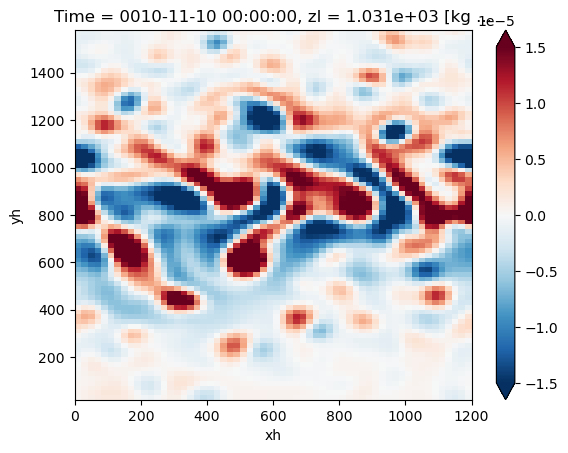

In [10]:
(ds_P2L_100.dvdx - ds_P2L_100.dudy).isel(Time=-1, zl=0).plot(vmin=-1.5e-5)

### APE reduction

In [11]:
def add_PE_reduction_rate(ds): 
    
    ds = ds.copy()

    dx = ds.xh.diff('xh').values[0] * 1e3
    dy = ds.yh.diff('yh').values[0] * 1e3
    dA = dx*dy
    print(dA)

    ds_Tsel = ds.isel(Time=slice(36, 360))
    
    ds['APE_reduce_rate'] = dA* 1031. * 1.96e-02* (ds_Tsel.uphp * ds_Tsel.dhdx + ds_Tsel.vphp * ds_Tsel.dhdy).isel(zl=1).isel(Time=slice(36, 360)).mean('Time').sum(['xh', 'yh'])

    ds['APE_reduce_rate_mean'] = dA* 1031. * 1.96e-02* (ds_Tsel.uphp.mean('Time') * ds_Tsel.dhdx.mean('Time') + 
                                                            ds_Tsel.vphp.mean('Time') * ds_Tsel.dhdy.mean('Time')
                                                           ).isel(zl=1).sum(['xh', 'yh'])
    ds['APE_reduce_rate_eddy'] = ds['APE_reduce_rate'] - ds['APE_reduce_rate_mean']

    #ds['APE_reduce_rate'] = (ds.uphp * ds.dhdx + ds.vphp * ds.dhdy).isel(zl=1).isel(Time=slice(36, 360)).mean('Time')
    
    return ds

In [12]:
ds_P2L_100 = add_PE_reduction_rate(ds_P2L_100)

400000000.0


In [13]:
ds_P2L_50 = add_PE_reduction_rate(ds_P2L_50)

64000000.0


In [14]:
ds_P2L_100.APE_reduce_rate_mean.values/1e10

-2.142747013570033

In [15]:
ds_P2L_100.APE_reduce_rate_eddy.values/1e10

-2.010467659289724

In [10]:
ds_P2L_50.APE_reduce_rate.values/1e10

-1.4062800441381644

In [15]:
ds_DG = add_PE_reduction_rate(ds_DG)

In [29]:
emean_P2L = ds_P2L.ebar.isel(Time=slice(36, 360), zi=0).mean('Time')#.plot.contour()

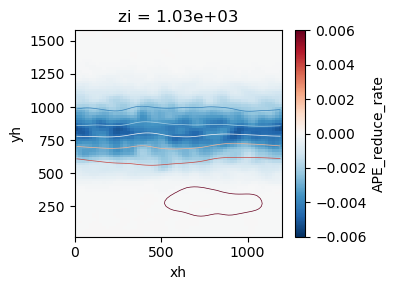

In [56]:
plt.figure(figsize=(4,3))
ds_P2L.APE_reduce_rate.plot(vmin = -6e-3)
emean_P2L.plot.contour(levels=np.linspace(-0.6, 0.6, 7), linewidths=0.5)
plt.tight_layout()
plt.savefig('filt_100.png')

In [31]:
emean_DG = ds_DG.ebar.isel(Time=slice(36, 360), zi=0).mean('Time')#.plot.contour()

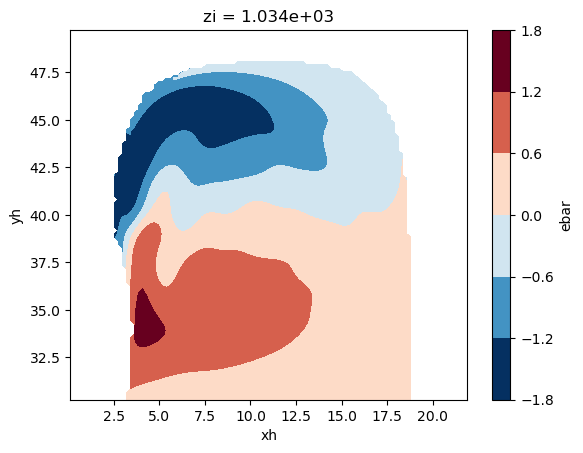

In [50]:
emean_DG.plot.contourf(levels=np.linspace(-1.8, 1.8, 7))


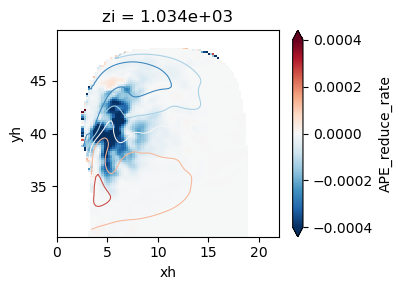

In [57]:
plt.figure(figsize=(4.2,3))

ds_DG.APE_reduce_rate.plot(vmin = -4e-4)
emean_DG.plot.contour(levels=np.linspace(-1.8, 1.8, 7), linewidths=0.75)
plt.tight_layout()
plt.savefig('filt_100_DG.png')

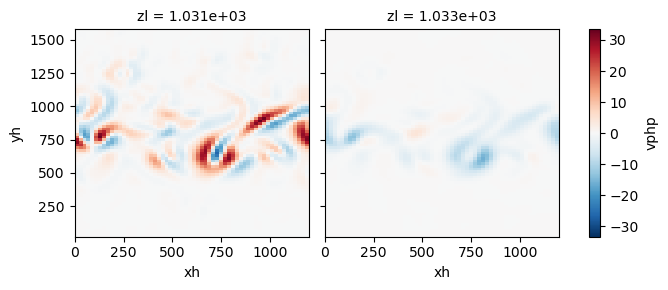

In [7]:
ds_P2L.vphp.isel(Time=-1).plot(col='zl')

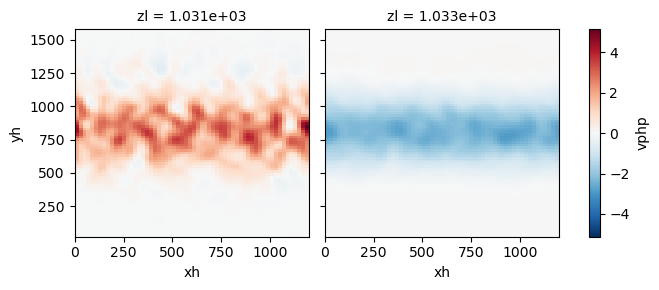

In [4]:
ds_P2L.vphp.isel(Time=slice(-400,None)).mean('Time').plot(col='zl')

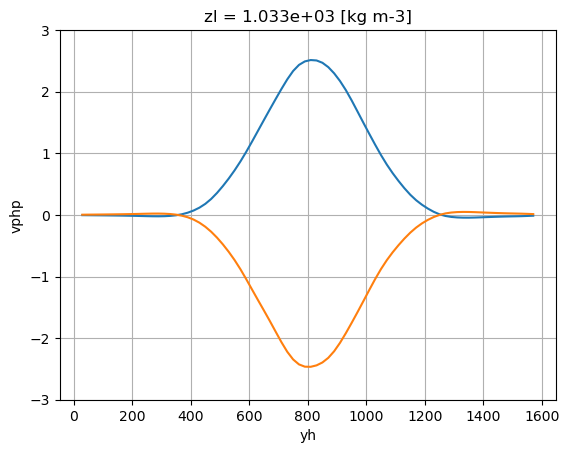

In [10]:
ds_P2L.vphp.isel(Time=slice(-400,None)).mean(['Time','xh']).isel(zl=0).plot()
ds_P2L.vphp.isel(Time=slice(-400,None)).mean(['Time','xh']).isel(zl=1).plot()
plt.ylim([-3, 3])
plt.grid()

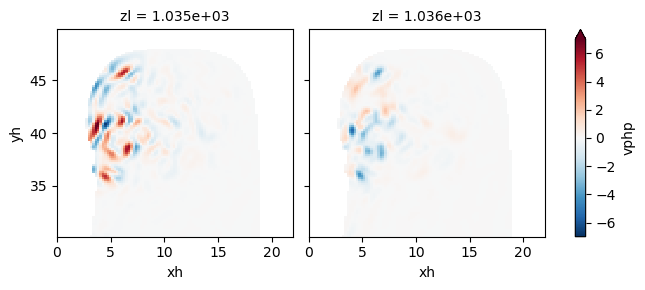

In [9]:
ds_DG.vphp.isel(Time=-1).plot(col='zl', vmin=-7)

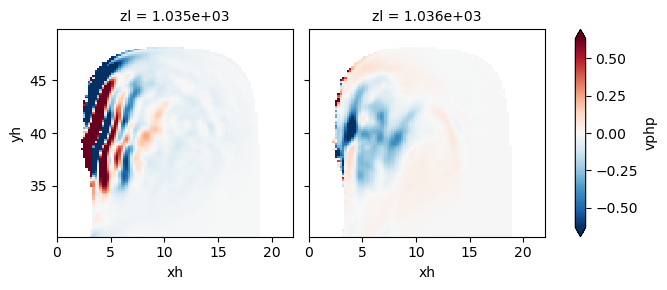

In [6]:
ds_DG.vphp.isel(Time=slice(-1000,None)).mean('Time').plot(col='zl', robust=True)

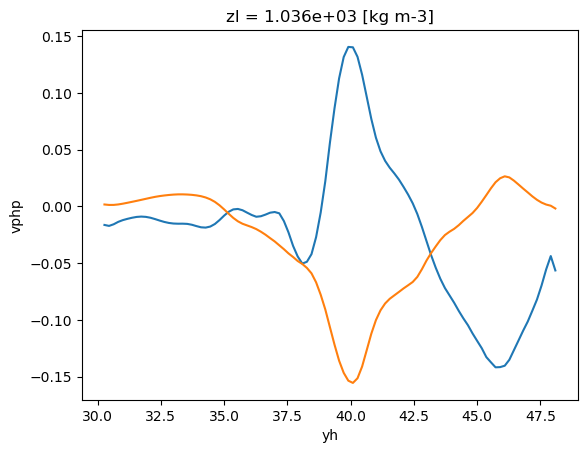

In [26]:
ds_DG.vphp.isel(Time=slice(-1000,None)).mean(['Time','xh']).isel(zl=0).plot()
ds_DG.vphp.isel(Time=slice(-1000,None)).mean(['Time','xh']).isel(zl=1).plot()

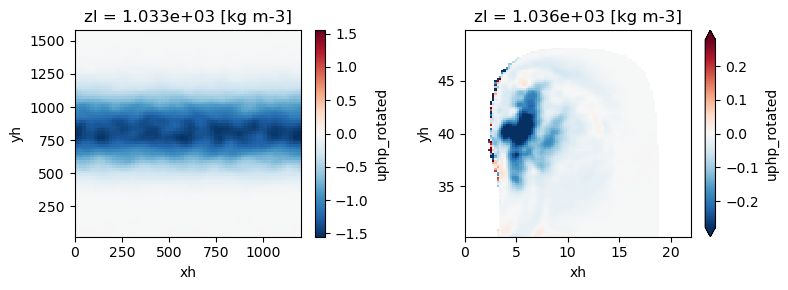

In [33]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-1000,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-1000,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

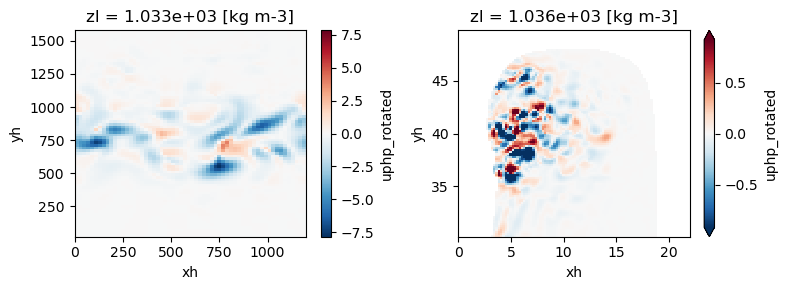

In [35]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-1,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-1,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

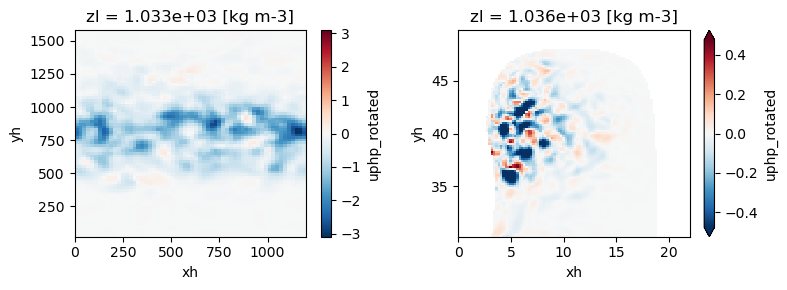

In [36]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-10,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-10,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

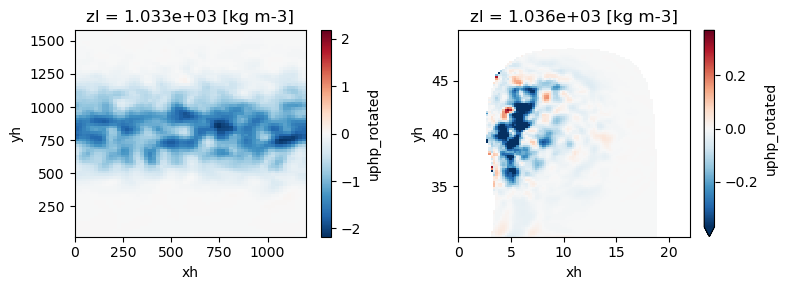

In [37]:
plt.figure(figsize=(8, 3))

plt.subplot(121)
ds_P2L.uphp_rotated.isel(Time=slice(-50,None), zl=1).mean('Time').plot()

plt.subplot(122)
ds_DG.uphp_rotated.isel(Time=slice(-50,None), zl=1).mean('Time').plot(robust=True)

plt.tight_layout()

In [39]:
ds_P2L.uphp_rotated.coarsen(Time=10)

DataArrayCoarsen [windows->{'Time': 10},side->left]

In [44]:
TS = ds_P2L.uphp_rotated.isel(zl=1).sel(xh=500, yh=800, method='nearest')

In [46]:
TS.load()

<xarray.DataArray 'uphp_rotated' (Time: 3600)> Size: 29kB
array([ 2.64586703e-04, -1.26606778e-03,  2.71231004e-03, ...,
       -3.39854503e+00, -2.60635933e+00,  1.48906190e+00])
Coordinates:
  * Time     (Time) object 29kB 0001-01-11 00:00:00 ... 0099-07-26 00:00:00
    xh       float64 8B 510.0
    yh       float64 8B 810.0
    zl       float64 8B 1.033e+03

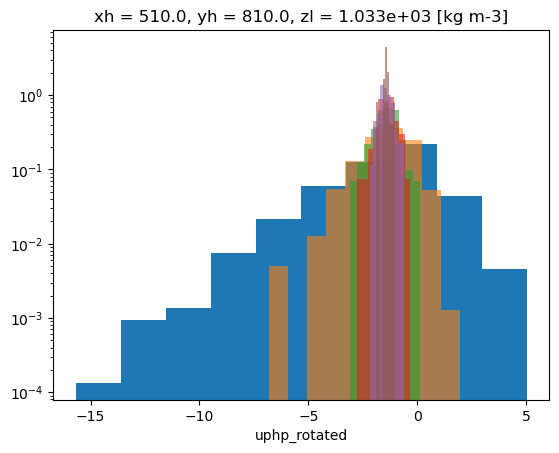

In [55]:
TS.plot.hist(density=True)
TS.coarsen(Time=4, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=16, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=32, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=64, boundary="trim").mean().plot.hist(density=True, alpha=0.6)
TS.coarsen(Time=128, boundary="trim").mean().plot.hist(density=True, alpha=0.6)

plt.yscale('log')

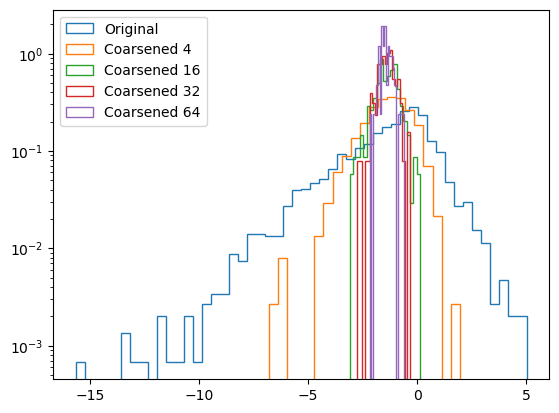

In [58]:
import matplotlib.pyplot as plt

# Plot the original histogram
plt.hist(TS, bins=50, density=True, histtype="step", label="Original")

# Define coarsening scales
coarsening_scales = [4, 16, 32, 64]

# Plot coarsened histograms
for scale in coarsening_scales:
    coarsened_TS = TS.coarsen(Time=scale, boundary="trim").mean()
    plt.hist(coarsened_TS, bins=21, density=True, histtype="step", label=f"Coarsened {scale}")

plt.yscale("log")
plt.legend()
plt.show()
